In [25]:
import sys
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as assembly, master_domain
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos de _Nedelec_ do tipo 1, $N_0$, em $R^2$ para resolver o Problema de Valor de Contorno vetorial $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
## Geometry and mesh Domain

In [26]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
h = 0.1
mesh_data = ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, view_mesh=False)

Malha salva em pre_processing/mesh/vectorial_poisson_domain_Triangle1.msh
Model vectorial_poisson (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 514 nodes in total
Info     : 946 2-D elements in total


# Figure 1: Vectorial Shape Functions

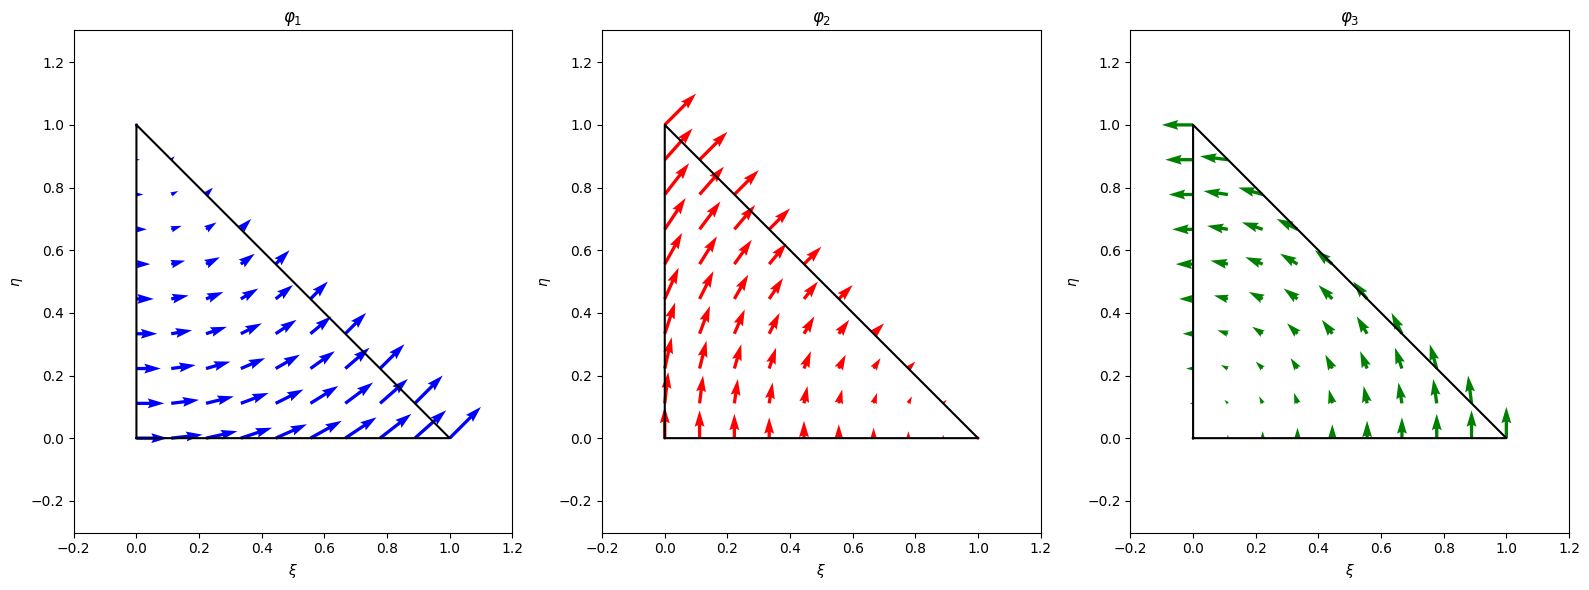

In [27]:
ps.plot_shape_functions_n0()

# Figure 2: Meshed domain

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_poisson_problem\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


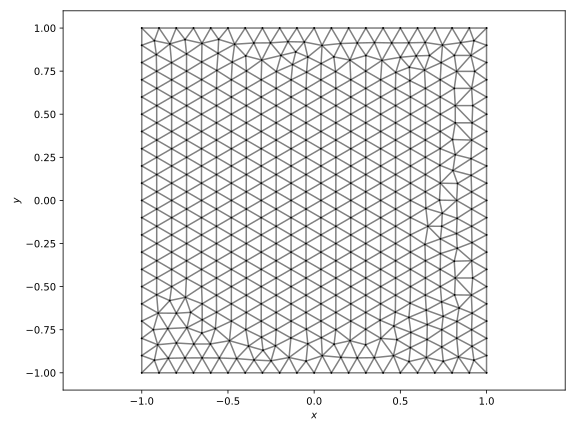

In [28]:
if h in [2, 1]:
    graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=True, show_edges=True)
else:
    graph_results.plot_mesh(FINITE_ELEMENT, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

In [29]:
mesh_data['cell'][1]

{'conn': [461, 418, 492],
 'conn_sorted': [418, 461, 492],
 'contour': {'type': None, 'conn_contour': None},
 'material': {'tag': 201, 'name': 'free_space', 'a_constant': 1},
 'centroid': (-0.10578763086092084, -0.8469817622930408),
 'stiffness_term': [array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]])],
 'mass_term': [1, 1, 1, 1, 1, 1, 1],
 'source': [array([[-9.06542861],
         [-5.99943814]]),
  array([[-10.64434446],
         [ -4.86355892]]),
  array([[-8.04336257],
         [-5.50822705]]),
  array([[-8.42397522],
         [-7.59226699]]),
  array([[-6.32052127],
         [-7.95870719]]),
  array([[-10.61745925],
         [ -6.65592988]]),
  array([[-10.0240538 ],
         [ -3.26418313]])],
 'conn_edge': [81, 82, 83]}

In [30]:
{key: cell['conn_edge'] for key, cell in mesh_data['cell'].items()}

{1: [81, 82, 83],
 2: [84, 85, 86],
 3: [87, 88, 89],
 4: [90, 91, 83],
 5: [92, 93, 94],
 6: [93, 95, 96],
 7: [97, 98, 99],
 8: [100, 97, 101],
 9: [102, 103, 104],
 10: [105, 106, 107],
 11: [105, 109, 108],
 12: [110, 111, 98],
 13: [110, 113, 112],
 14: [114, 116, 115],
 15: [114, 117, 95],
 16: [118, 119, 120],
 17: [118, 122, 121],
 18: [123, 109, 124],
 19: [123, 125, 101],
 20: [126, 128, 127],
 21: [126, 113, 129],
 22: [130, 131, 86],
 23: [132, 133, 134],
 24: [135, 136, 137],
 25: [107, 138, 134],
 26: [139, 140, 137],
 27: [141, 143, 142],
 28: [144, 146, 145],
 29: [147, 148, 149],
 30: [127, 147, 150],
 31: [151, 152, 153],
 32: [154, 155, 130],
 33: [156, 157, 158],
 34: [159, 161, 160],
 35: [162, 163, 160],
 36: [89, 165, 164],
 37: [166, 168, 167],
 38: [169, 170, 167],
 39: [103, 171, 172],
 40: [87, 174, 173],
 41: [155, 175, 176],
 42: [157, 177, 178],
 43: [141, 179, 180],
 44: [144, 181, 182],
 45: [62, 184, 183],
 46: [2, 186, 185],
 47: [22, 188, 187],
 48: [

## Linear Functional

In [31]:
ui = {}
for key, edge in mesh_data['edges'].items():
    # Coordenadas dos nós inicial e final
    xe_0, ye_0 = mesh_data['nodes'][edge[0]]['xg']
    xe_1, ye_1 = mesh_data['nodes'][edge[1]]['xg']
    
    # Ponto médio da aresta
    xmid, ymid = (xe_0 + xe_1) / 2, (ye_0 + ye_1) / 2
    
    # Vetor tangente à aresta
    tangent_vector = np.array([[xe_1 - xe_0], [ye_1 - ye_0]])

    # Campo vetorial no ponto médio da aresta, u(x_mid, y_mid) 
    u_vector = ps.analytical_function(xmid, ymid)

    # Produto escalar entre o campo vetorial e o vetor tangente
    ## O método .item() extrai o valor escalar de um array de tamanho 1x1
    ui[key] = (u_vector.T @ tangent_vector).item()

## Solution at each element

In [ ]:
u_at_cell = {}
xik_master = (1/3, 1/3)
for key, cell in mesh_data['cell'].items():    
    Je = assembly.edge_jacobian(mesh_data, cell)    
    JinvT = np.linalg.inv(Je).T
    phi_hat = master_domain.shape_functions_n0(*xik_master)
    u_at_cell[key] = 0
    for i, edge in enumerate(cell['conn_edge']):
        u_at_cell[key] += ui[edge] * (JinvT @ phi_hat[i])

## Interpolation of Analytical Solution 

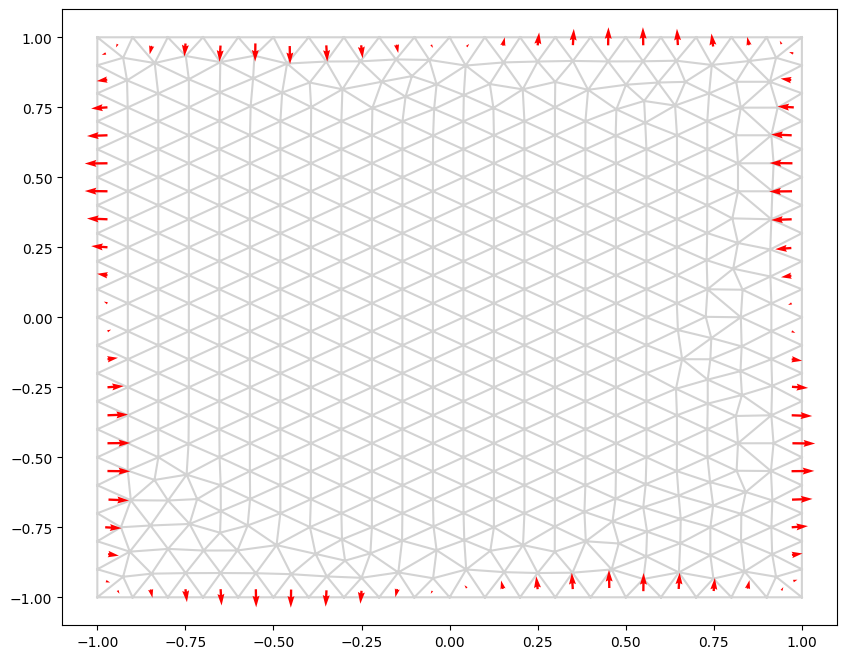

In [34]:
# Extraindo as coordenadas globais dos nós (x, y) e a matriz de conectividade
xg, yg, conn_py = graph_results.structured_data(mesh_data)

# Criando a malha
plt.figure(figsize=(10, 8))
plt.triplot(xg, yg, conn_py, color='lightgray')

# Adicionando os vetores ao gráfico
for key, cell in mesh_data['cell'].items():
    if cell['contour']['type'] == 'Dirichlet':        
        xc, yc = cell['centroid']
        ux, uy = u_at_cell[key][0], u_at_cell[key][1]
        plt.quiver(xc, yc, ux, uy,
                    angles='xy', scale_units='xy', scale=15, color='r', width=0.003)

plt.show()

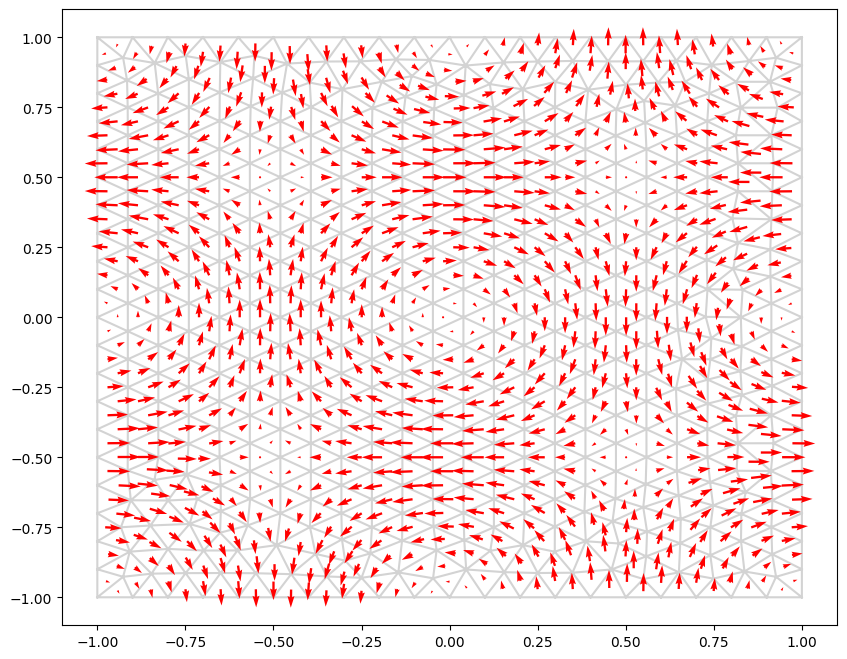

In [35]:
# Criando a malha
plt.figure(figsize=(10, 8))
plt.triplot(xg, yg, conn_py, color='lightgray')

# Adicionando os vetores ao gráfico
for key, cell in mesh_data['cell'].items():
    xc, yc = cell['centroid']
    ux, uy = u_at_cell[key][0], u_at_cell[key][1]
    plt.quiver(xc, yc, ux, uy,
                angles='xy', scale_units='xy', scale=15, color='r', width=0.003)

plt.show()

# `plot_analytical_solution()`

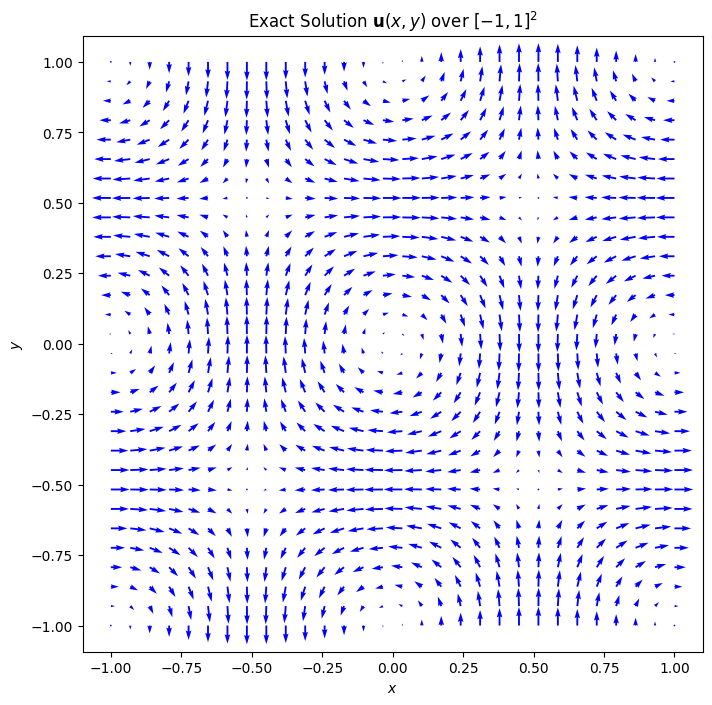

In [36]:
ps.plot_analytical_solution()

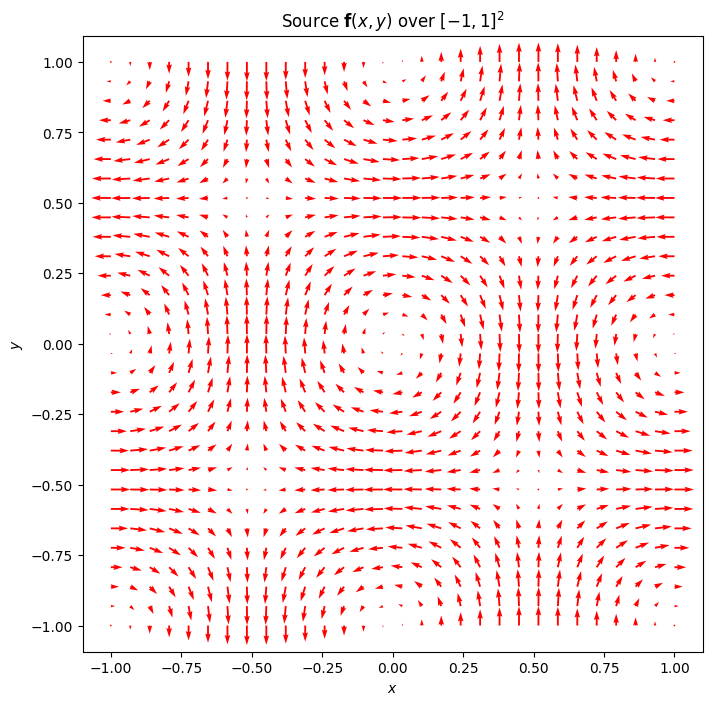

In [37]:
ps.plot_analytical_source()

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.